<a href="https://colab.research.google.com/github/arielfaur/prediccion-precio-propiedades-fmap-2020/blob/feature%2Fneural-network-keras-regressor/keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q git+https://github.com/tensorflow/docs

In [4]:
!pip install pyreadr

     |████████████████████████████████| 266kB 3.4MB/s 


In [89]:
# import libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
# %matplotlib inline
import sys
import os

from urllib.parse import urljoin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, QuantileTransformer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector, TransformedTargetRegressor
from sklearn.impute import SimpleImputer, KNNImputer

# from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble importGradientBoostingRegressor, VotingRegressor
# from sklearn.linear_model import LinearRegression
# from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, cross_val_predict, train_test_split

import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow import keras
from tensorflow.keras import layers,regularizers

import pyreadr

IS_COLAB = 'google.colab' in sys.modules

# palabras a buscar en columna descripción
TEXT_MINING_KEYWORDS = ['balcon', 'cochera', 'sum', 'parrilla', 'pileta']

# url repositorio
GITHUB_REPOSITORY_URL = 'https://github.com/arielfaur/prediccion-precio-propiedades-fmap-2020/raw/master/'
BASE_URL_DATA = GITHUB_REPOSITORY_URL if IS_COLAB else ''

def vectorize_descripcion(df: pd.DataFrame):
    
    # entrenamos el modelo para buscar las keywords
    vectorizer = CountVectorizer(binary=True, strip_accents='unicode')  
    vectorizer.fit(TEXT_MINING_KEYWORDS)

    # hot encoding de los resultados
    desc = vectorizer.transform(df['descripcion'])

    # crear dataframe con resultados
    df_desc = pd.DataFrame(data=desc.toarray(), columns=vectorizer.get_feature_names())
    return pd.concat([df.reset_index(drop=True), df_desc.reset_index(drop=True)], axis=1, sort=False)

def get_outliers(df: pd.DataFrame):
    return df[df_train['id'].isin(['7798', '31417', '10764', '12865', '22126', '49492'])]

def remove_outliers(df: pd.DataFrame):
    outliers = get_outliers(df)
    df.drop(outliers.index, inplace=True)

def preprocessing(df: pd.DataFrame, process_outliers = True):
    # nombres features en minuscula
    df.columns = map(str.lower, df.columns)

    df['barrio'] = df['barrio'].astype('category')
    df['cluster'] = df['cluster'].astype('category')
    df['id'] = df['id'].astype('int')
    
    # guardar los id
    ids = df['id']
    
    # eliminar outliers
    if process_outliers:
        remove_outliers(df)
    
    # text mining buscar keywords en descripcion
    df['descripcion'].fillna('', inplace=True)
    df = vectorize_descripcion(df)
    
    # eliminar columnas innecesarias del modelo
    df.drop([
        'banios',
        # 'barrio', 
        'subbarrio',
        'descripcion',
        'p_mt2', 
        'n_bancos',
        'n_barrios_p', 
        'n_bici', 
        'n_boliches', 
        'n_clinicas', 
        'n_comisarias',
        'n_embajadas', 
        'n_gasolina', 
        'n_gastronomica', 
        'n_homicidios',
        'n_hospitales', 
        'n_hurtos', 
        'n_hurtos_auto',
        'n_robo', 
        'n_robo_vehi',
        'n_subte_bocas', 
        'n_uni',
        'cluster',
        # 'terraza',
        'lujo',
        'sup_cubierta'
    ],axis=1, inplace=True, errors='raise')


    return ids, df.set_index('id')


def split_data(df: pd.DataFrame, test_size = 0.05):
    y = df[['precio']]
    X = df.drop(['precio'], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=5)
    return X_train, X_test, y_train, y_test


## Preprocesamiento de los features: imputación, estandarización, one-hot encoding
def make_transformer_pipeline():
    numeric_transformer = make_pipeline( 
        SimpleImputer(missing_values = np.nan, strategy='mean'),
        StandardScaler(),
    )

    categorical_transformer = make_pipeline(
        #SimpleImputer(strategy='constant', fill_value='missing'),
        #SimpleImputer(strategy="most_frequent"),
        #KNNImputer(n_neighbors=3, weights="uniform"),     # KNNImputer tarda una eternidad...
        OneHotEncoder(handle_unknown='ignore')
    )

    return make_column_transformer(
        (numeric_transformer, make_column_selector(dtype_include=['int64', 'float64'])),
        (categorical_transformer, make_column_selector(dtype_include=['category']))
    )    

def baseline_ada_model_pipeline():
    transformer = make_transformer_pipeline()
    ada = AdaBoostRegressor(random_state = 5)
    
    return make_pipeline(transformer, TransformedTargetRegressor(ada, func=np.log, inverse_func=np.exp))    

def create_train_ada_model():
    transformer = make_transformer_pipeline()

    model = Pipeline([
        ('preprocessing', transformer),
        ('model', TransformedTargetRegressor(AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), loss='square', random_state=5), func=np.log, inverse_func=np.exp))
    ])
    return model

# # Crear modelo red neuronal Keras
# def build_1layer_keras_model(input_dim, n_neurons = 8):    
#     model = keras.Sequential()
#     model.add(layers.Dense(n_neurons, activation='relu', input_dim=input_dim))
#     model.add(layers.Dense(1))
#     model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

#     return model

# Crear modelo red neuronal Keras
def build_dense_keras_model(input_dim, n_neurons = [8, 8], lr = 0.001, dropout = False):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model = keras.Sequential()
    for idx, n in enumerate(n_neurons):
        if idx==0:
            model.add(layers.Dense(n, activation='relu', kernel_initializer='random_normal', input_dim=input_dim))
            if dropout: model.add(layers.Dropout(.1))
        else:
            model.add(layers.Dense(n, activation='relu', kernel_initializer='random_normal'))
            if dropout: model.add(layers.Dropout(.1))
                
    model.add(layers.Dense(1, kernel_initializer='random_normal'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

# # Pipeline preprocesamiento para red neuronal
# def create_keras_pipeline():
#     EPOCHS = 300
#     BATCH_SIZE = 32

#     transformer = make_transformer_pipeline()
#     pipeline = Pipeline([
#         ('preprocessing', transformer),
#         ('model', TransformedTargetRegressor(KerasRegressor(build_fn=build_1layer_keras_model, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1), 
#         transformer=QuantileTransformer(output_distribution='normal', random_state=5)
#         ))
#     ])
#     return pipeline

# Graficar predicciones
def plot_test_predictions(y_test, y_pred):
    # graficar predicciones contra datos actuales
    fig, ax = plt.subplots(figsize = (18,10))
    ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Precio test')
    ax.set_ylabel('Precio predicción')
    plt.show()

def read_rds(filename):
  from urllib.request import urlopen
  
  response = urlopen(filename)
  content = response.read()
  fhandle = open('data', 'wb')
  fhandle.write(content)
  fhandle.close()
  result = pyreadr.read_r('data')
  return result[None]

In [90]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Initializing the TPU system: grpc://10.121.160.178:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.121.160.178:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU')]


# Cargar datos entrenamiento

In [91]:
df_train = read_rds(urljoin(BASE_URL_DATA,'data_train_def.rds'))

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20371 entries, 0 to 20370
Data columns (total 34 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20371 non-null  object 
 1   lat             20371 non-null  float64
 2   lon             20371 non-null  float64
 3   precio          20371 non-null  float64
 4   BARRIO          20371 non-null  object 
 5   n_uni           20371 non-null  int32  
 6   n_boliches      20371 non-null  int32  
 7   n_clinicas      20371 non-null  int32  
 8   n_hospitales    20371 non-null  int32  
 9   sup_cubierta    20371 non-null  float64
 10  n_comisarias    20371 non-null  int32  
 11  n_embajadas     20371 non-null  int32  
 12  n_subte_bocas   20371 non-null  int32  
 13  n_barrios_p     20371 non-null  int32  
 14  n_bici          20371 non-null  int32  
 15  n_bancos        20371 non-null  int32  
 16  A_Estrenar      20371 non-null  float64
 17  banios          20371 non-null 

In [ ]:
df_train.describe()

## Preprocesamiento

In [92]:
ids, df_train = preprocessing(df_train)
df_train.head()

,lat,lon,precio,barrio,a_estrenar,dormitorios,sup_total,habitaciones,terraza,balcon,cochera,parrilla,pileta,sum
id,,,,,,,,,,,,,,
4,-34.600886,-58.431204,145000.0,villa crespo,0.0,2.0,57.0,3.0,0.0,0,0,0,0,0
6,-34.572144,-58.480173,237000.0,villa urquiza,0.0,2.0,60.0,3.0,1.0,1,0,0,0,0
8,-34.563209,-58.468897,130000.0,coghlan,0.0,1.0,49.0,2.0,1.0,1,0,0,0,0
11,-34.555333,-58.466432,230000.0,nuñez,0.0,2.0,55.0,3.0,1.0,1,1,0,0,0
12,-34.629200,-58.452566,144900.0,flores,1.0,1.0,48.0,2.0,1.0,1,0,1,0,0


In [93]:
test_size = round(2500 / len(df_train), 2)
test_size

0.12

In [94]:
X_train, X_test, y_train, y_test = split_data(df_train, test_size=test_size)

In [95]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17921, 13), (2444, 13), (17921, 1), (2444, 1))

In [ ]:
sns.pairplot(df_train, vars=['sup_total','habitaciones','precio'], hue='cluster', height=3)

# Pipeline preprocesamiento

In [96]:
pipe = make_transformer_pipeline()
X_train = pipe.fit_transform(X_train).toarray()
y_train = y_train.values

In [97]:
X_train, y_train

(array([[ 0.84540209,  0.95209473, -0.39275613, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.49640854,  0.63657231, -0.39275613, ...,  0.        ,
          0.        ,  0.        ],
        [-1.45550193, -0.73194261, -0.39275613, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 1.13721597,  0.19559168, -0.39275613, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.66476808,  0.33972116, -0.39275613, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.53212571, -1.03902861, -0.39275613, ...,  0.        ,
          0.        ,  0.        ]]), array([[210000.],
        [205500.],
        [111000.],
        ...,
        [330000.],
        [196531.],
        [120000.]]))

(array([1.061e+03, 8.709e+03, 5.972e+03, 1.634e+03, 4.190e+02, 9.700e+01,
        2.100e+01, 4.000e+00, 3.000e+00, 1.000e+00]),
 array([ 20000.,  75798., 131596., 187394., 243192., 298990., 354788.,
        410586., 466384., 522182., 577980.]),
 <a list of 10 Patch objects>)

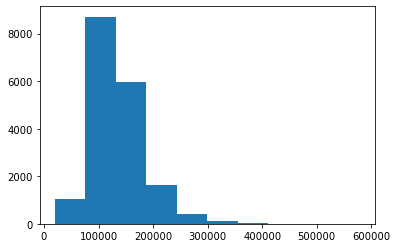

In [ ]:
plt.hist(y_train)

# Modelo red densa Keras

In [98]:
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [99]:
EPOCHS = 2000
BATCH_SIZE = 32
STEPS_PER_EPOCH = X_train.shape[0]//BATCH_SIZE

initial_learning_rate = 0.01

# lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
#   initial_learning_rate,
#   decay_steps=STEPS_PER_EPOCH*100,
#   decay_rate=1,
#   staircase=False)


# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=1400,
#     decay_rate=0.95,
#     staircase=False)

# tfa.optimizers.AdamW(learning_rate=0.01, weight_decay=1e-4)
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
initializer = tf.keras.initializers.he_uniform()    

print(STEPS_PER_EPOCH)

560


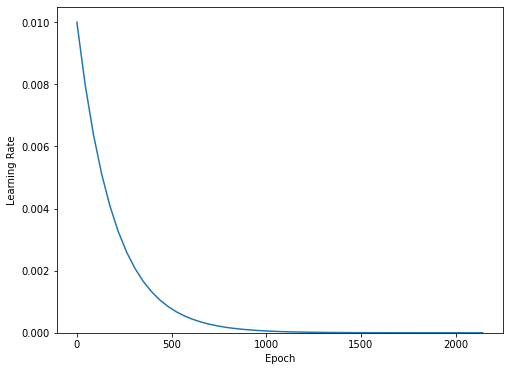

In [77]:
step = np.linspace(0,300000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [100]:
with strategy.scope():
  model = keras.Sequential()
  model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(0.001), input_dim=X_train.shape[1]))
  # model.add(layers.Dropout(rate=.1))
  model.add(layers.Dense(64, activation='relu', kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
  # model.add(layers.Dropout(rate=.1))
  # model.add(layers.Dense(64, activation='relu', kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
  # model.add(layers.Dropout(rate=.1))
  model.add(layers.Dense(1))
  model.compile(loss='mean_squared_error', 
                optimizer=optimizer, 
                experimental_steps_per_execution = 50,  # Anything between 2 and `steps_per_epoch` could help here.
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 128)               7296      
_________________________________________________________________
dense_52 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 65        
Total params: 15,617
Trainable params: 15,617
Non-trainable params: 0
_________________________________________________________________


In [101]:
# Callbacks #

# Parar entrenamiento cuando no mejora MSE
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=300)

# Guardar modelo entrenado
# checkpoint = keras.callbacks.ModelCheckpoint('modelo_prediccion_propiedades.hdf5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')

# Reducir learning rate cuando no mejora MSE
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=50, min_lr=0.0001)


history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    # steps_per_epoch = STEPS_PER_EPOCH,
                    validation_split = 0.05, 
                    callbacks=[tfdocs.modeling.EpochDots(), early_stop],
                    verbose=1)

Epoch 1/2000
532/532 [==============================] - ETA: 0s - loss: 4798057472.0000 - root_mean_squared_error: 69268.0078
Epoch: 0, loss:4798057472.0000,  root_mean_squared_error:69268.0078,  val_loss:1183988992.0000,  val_root_mean_squared_error:34409.1406,  
532/532 [==============================] - 4s 7ms/step - loss: 4798057472.0000 - root_mean_squared_error: 69268.0078 - val_loss: 1183988992.0000 - val_root_mean_squared_error: 34409.1406
Epoch 2/2000
532/532 [==============================] - 1s 3ms/step - loss: 931897856.0000 - root_mean_squared_error: 30527.0039 - val_loss: 1099326208.0000 - val_root_mean_squared_error: 33156.0859
Epoch 3/2000
532/532 [==============================] - 1s 3ms/step - loss: 891835648.0000 - root_mean_squared_error: 29863.6152 - val_loss: 1063211328.0000 - val_root_mean_squared_error: 32606.9219
Epoch 4/2000
532/532 [==============================] - 1s 3ms/step - loss: 872943296.0000 - root_mean_squared_error: 29545.6133 - val_loss: 105792972

Exception ignored in: <bound method IteratorResourceDeleter.__del__ of <tensorflow.python.data.ops.iterator_ops.IteratorResourceDeleter object at 0x7fd686e17550>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 537, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1282, in delete_iterator
    _ops.raise_from_not_ok_status(e, name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 6843, in raise_from_not_ok_status
    six.raise_from(core._status_to_exception(e.code, message), None)
  File "<string>", line 3, in raise_from
tensorflow.python.framework.errors_impl.InvalidArgumentError: Resource input tensor contains an invalid device. This might happen when the client has connected to a different cluster, or some remote workers have been restarted. [Op:DeleteIterato

532/532 [==============================] - 2s 5ms/step - loss: 730202304.0000 - root_mean_squared_error: 27022.2559 - val_loss: 934335552.0000 - val_root_mean_squared_error: 30566.8984
Epoch 43/2000
532/532 [==============================] - 2s 3ms/step - loss: 728004224.0000 - root_mean_squared_error: 26981.5527 - val_loss: 938211648.0000 - val_root_mean_squared_error: 30630.2383
Epoch 44/2000
532/532 [==============================] - 2s 3ms/step - loss: 727376768.0000 - root_mean_squared_error: 26969.9199 - val_loss: 949159104.0000 - val_root_mean_squared_error: 30808.4219
Epoch 45/2000
532/532 [==============================] - 2s 3ms/step - loss: 724962496.0000 - root_mean_squared_error: 26925.1270 - val_loss: 940958080.0000 - val_root_mean_squared_error: 30675.0410
Epoch 46/2000
532/532 [==============================] - 2s 3ms/step - loss: 724493952.0000 - root_mean_squared_error: 26916.4219 - val_loss: 932783104.0000 - val_root_mean_squared_error: 30541.4961
Epoch 47/2000
532/5

# Graficar métricas entrenamiento

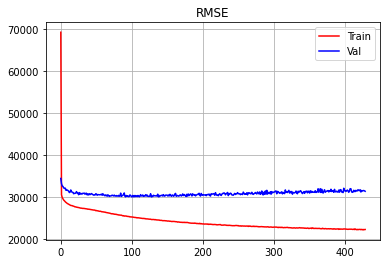

In [102]:
train_rmse = history.history['root_mean_squared_error']

val_rmse = history.history['val_root_mean_squared_error']


plt.plot(np.linspace(0, len(train_rmse),  len(train_rmse)), train_rmse,
             color='red', label='Train')

plt.plot(np.linspace(0, len(val_rmse), len(val_rmse)), val_rmse,
         color='blue', label='Val')

plt.title('RMSE')
plt.legend()
plt.grid(True)
plt.show()

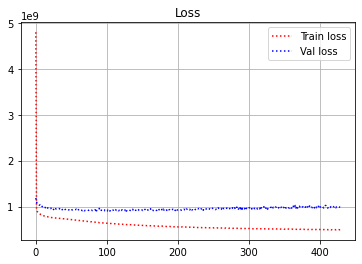

In [103]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(np.linspace(0, len(train_loss),  len(train_loss)), train_loss, 'r:',
             color='red', label='Train loss')
plt.plot(np.linspace(0, len(val_loss),  len(val_loss)), val_loss, 'b:',
             color='blue', label='Val loss')

plt.title('Loss')
plt.legend()
plt.grid(True)
plt.show()

(array([174., 894., 857., 323., 140.,  35.,  12.,   5.,   2.,   2.]),
 array([ 35700. ,  78649.2, 121598.4, 164547.6, 207496.8, 250446. ,
        293395.2, 336344.4, 379293.6, 422242.8, 465192. ]),
 <a list of 10 Patch objects>)

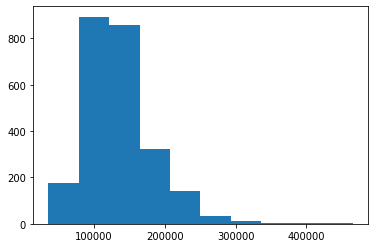

In [105]:
X_test = pipe.fit_transform(X_test).toarray()
y_test = y_test.values
plt.hist(y_test)

In [106]:
loss, rmse = model.evaluate(X_test, y_test, verbose=2)
print("Testing set RMSE: {:5.2f}".format(rmse))

77/77 - 1s - loss: 883928832.0000 - root_mean_squared_error: 29730.9258
Testing set RMSE: 29730.93


In [107]:
y_pred = model.predict(X_test).flatten()
y_pred

array([100503.23 , 167506.16 , 143263.08 , ..., 118271.43 , 105087.06 ,
       128475.586], dtype=float32)

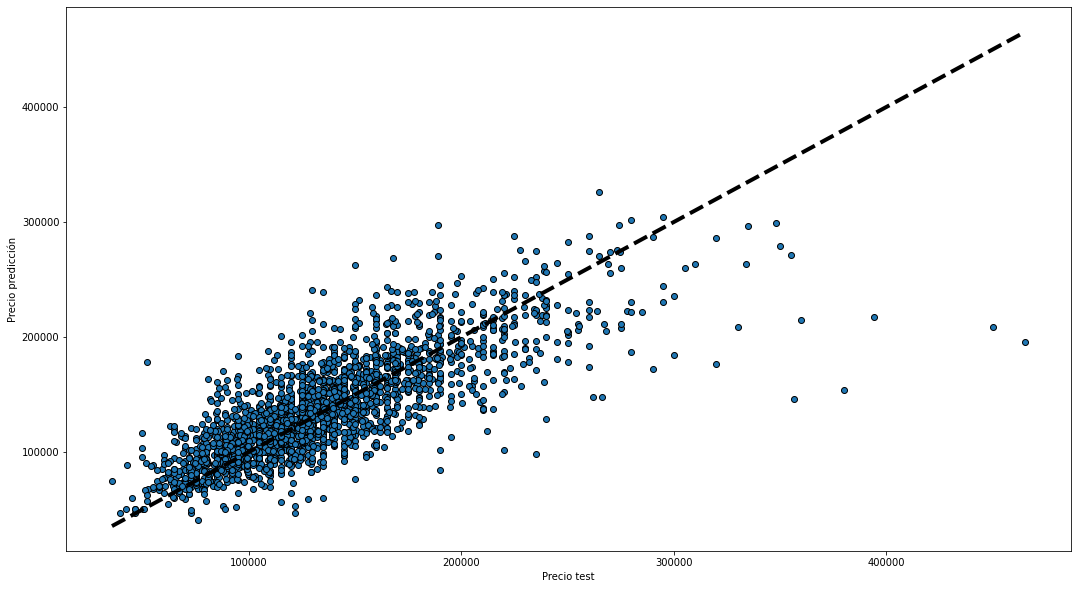

In [108]:
plot_test_predictions(y_test, y_pred)

# Preprocesamiento set de test

In [ ]:
df_test = read_rds(urljoin(BASE_URL_DATA,'data_test_def.rds'))
df_test.head()

In [ ]:
df_test.info()

In [ ]:
ids, df_test = preprocessing(df_test, process_outliers=False)

In [ ]:
df_test.head()

In [ ]:
df_test.drop(['precio'], axis=1, inplace=True)
df_test.head()

# Predicción con red neuronal

In [ ]:
X = pipe.transform(df_test)
X.shape

In [ ]:
y_pred = model.predict(X).flatten()
data = pd.DataFrame(data={'id' : ids.values, 'precio': np.round(y_pred).astype(int) })
data

In [ ]:
data.to_csv('propiedades_prediccion.csv', index=False)